In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Found 862 images belonging to 2 classes.
Found 214 images belonging to 2 classes.
(32, 200, 200, 3)


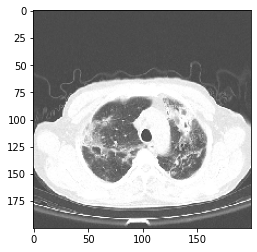

(32, 200, 200, 3)


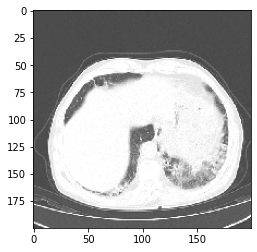

(32, 200, 200, 3)


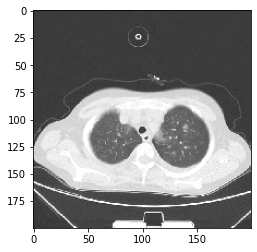

(32, 200, 200, 3)


(32, 200, 200, 3)


In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc


path_dir = '/content/gdrive/MyDrive/COVID-19 and common pneumonia chest CT dataset.rar (Unzipped Files)/datasets'

train_datagen =ImageDataGenerator(
    rescale=(1/255.),validation_split=0.2,
    preprocessing_function=lambda x: x[..., np.random.permutation([0, 1, 2])]
)
img_height =200
img_width =200

batch_size =32

train_generator = train_datagen.flow_from_directory(
    path_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    path_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    subset='validation')

for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing import image
from tensorflow.keras.models import load_model




In [14]:
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fourth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# # The fifth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.2),
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [15]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_generator,
steps_per_epoch=8,
epochs=10,
verbose=1,
validation_data = validation_generator,
validation_steps=8)

Epoch 1/10
8/8 [==============================] - 7s 827ms/step - loss: 0.7467 - accuracy: 0.5236 - val_loss: 0.6154 - val_accuracy: 0.6963
Epoch 2/10
8/8 [==============================] - 2s 252ms/step - loss: 0.7368 - accuracy: 0.6220
Epoch 3/10
8/8 [==============================] - 2s 254ms/step - loss: 0.7360 - accuracy: 0.4685
Epoch 4/10
8/8 [==============================] - 2s 270ms/step - loss: 0.6905 - accuracy: 0.5000
Epoch 5/10
8/8 [==============================] - 3s 302ms/step - loss: 0.6940 - accuracy: 0.4685
Epoch 6/10
8/8 [==============================] - 3s 395ms/step - loss: 0.6887 - accuracy: 0.6250
Epoch 7/10
8/8 [==============================] - 2s 267ms/step - loss: 0.6654 - accuracy: 0.8477
Epoch 8/10
8/8 [==============================] - 2s 263ms/step - loss: 0.6837 - accuracy: 0.6220
Epoch 9/10
8/8 [==============================] - 2s 264ms/step - loss: 0.5830 - accuracy: 0.7480
Epoch 10/10
8/8 [==============================] - 2s 266ms/step - loss: 1.5

In [16]:
model.evaluate(validation_generator)

7/7 [==============================] - 2s 229ms/step - loss: 0.6051 - accuracy: 0.6963


[0.6050544381141663, 0.6962617039680481]

In [18]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

y_pred = [0 if x <0.5 else 1 for x in preds]
y_true = validation_generator.labels

from sklearn.metrics import f1_score,accuracy_score
print('f1 score',f1_score(y_true, y_pred))


# saving and loading the .h5 model

# save model
model.save('gfgModel.h5')
print('Model Saved!')

# load model
savedModel=load_model('gfgModel.h5')
savedModel.summary()



7/7 [==============================] - 2s 245ms/step
f1 score 0.8209366391184573
Model Saved!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 64)        18496     
                          

In [19]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [20]:
roc_auc = auc(fpr, tpr)

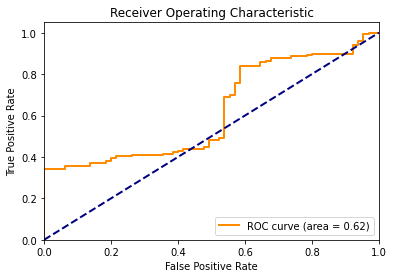

In [21]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()